In [14]:
import pandas  as pd
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import os
from utils import run_kfold_eval, calculate_metric
import optuna
import time
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
import joblib
from pathlib import Path

In [5]:
DATA_FOLDER = "../data"
TRAIN_FEATURES = DATA_FOLDER + '/train_features2.xlsx'
TRAIN_LABELS = DATA_FOLDER + "/train_labels2.xlsx"
TEST_FEATURES = DATA_FOLDER + "/test_features2.xlsx"
TEST_LABELS = DATA_FOLDER + "/test_labels2.xlsx"
OUTPUT_PATH = '../output/elastic_reg'

In [6]:
# create path
output_dir = Path(OUTPUT_PATH)
output_dir.mkdir(parents=True, exist_ok=True)

In [7]:
train_features = pd.read_excel(TRAIN_FEATURES)
train_labels = pd.read_excel(TRAIN_LABELS)
test_features = pd.read_excel(TEST_FEATURES)
test_labels = pd.read_excel(TEST_LABELS)

In [8]:
test_features.head()

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,3.125,-122.39680,-0.001341,1.116103,396.408936,399.031738,455.0625,383.612488,341.675812,0.1734,...,False,False,False,False,False,False,False,False,False,False
1,15.000,156.01912,0.000790,6.372588,107.083778,76.414360,118.2482,113.403519,147.756165,0.0253,...,False,False,False,False,False,False,False,False,False,False
2,0.000,-451.10824,-0.002033,43.914617,637.607544,689.770996,683.3611,589.969666,529.166992,0.0406,...,False,False,False,True,False,False,False,False,False,False
3,5.875,-751.22120,-0.000435,74.783398,153.653778,129.425842,158.3252,172.708054,187.147980,1.4908,...,False,False,False,False,False,False,False,False,False,False
4,10.000,55.69036,0.000712,-28.522133,152.290619,148.385330,222.1811,142.140915,159.624313,0.0763,...,False,False,False,False,False,False,False,False,False,False


In [9]:
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

(1293, 317)
(1293, 1)
(432, 317)
(432, 1)


In [10]:
feature_list = train_features.columns
# category_feature_key = ['currency', 'seniorioty_adj', 'domicile_country',	'exchange_country',	'Industry_sector',	'Industry_group',	'Industry_subgroup', 'event_type',
#                  'event_type_subcategory_sum', 'defaulted_in_last_6_months']
# category_features = [i for i in feature_list if any(sub in i for sub in category_feature_key)]
category_features = train_features.select_dtypes(include=['int', 'bool']).columns
non_category_features = [i for i in feature_list if i not in category_features]

print(len(category_features))
print(len(non_category_features))

164
153


In [11]:
category_features

Index(['defaulted_in_last_5_years', 'defaulted_in_last_6_months',
       'currency_CAD', 'currency_CHF', 'currency_CNY', 'currency_EUR',
       'currency_GBP', 'currency_HKD', 'currency_INR', 'currency_ISK',
       ...
       'event_type_subcategory_sum_Missing Coupon payment only',
       'event_type_subcategory_sum_Missing Interest payment',
       'event_type_subcategory_sum_Missing Loan payment',
       'event_type_subcategory_sum_Missing Principal payment',
       'event_type_subcategory_sum_Others',
       'event_type_subcategory_sum_Pre-Negotiated Chapter 11',
       'event_type_subcategory_sum_Protection',
       'event_type_subcategory_sum_Receivership',
       'event_type_subcategory_sum_Rehabilitation',
       'event_type_subcategory_sum_Restructuring'],
      dtype='object', length=164)

In [12]:
# Normalize the data
# Prepare the ColumnTransformer

scaler = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), non_category_features)   # StandardScaler()
    ],
    remainder='passthrough'  # Leave categorical features untouched
)

In [15]:
def objective(trial):

    alpha = trial.suggest_float('alpha', 0.01, 10, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    
    # Create the pipeline with the current hyperparameters
    pipeline = Pipeline([
        ('scaler', scaler),
        ('elastic_net', ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio, 
            max_iter=10000,
            tol=1e-4,
            random_state=42
        ))
    ])
    
    score = cross_val_score(pipeline, train_features, train_labels['rr1_30'].to_numpy(), cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return score

In [16]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-03-31 13:38:58,282] A new study created in memory with name: no-name-b98b895b-b3cf-47f6-8c92-82d1d80dccb0


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-03-31 13:39:06,189] Trial 0 finished with value: -0.1085148053872298 and parameters: {'alpha': 5.155828374684812, 'l1_ratio': 0.960892095046558}. Best is trial 0 with value: -0.1085148053872298.
[I 2025-03-31 13:39:09,554] Trial 1 finished with value: -0.1085148053872298 and parameters: {'alpha': 0.6985154633446239, 'l1_ratio': 0.8386578022744656}. Best is trial 0 with value: -0.1085148053872298.
[I 2025-03-31 13:39:09,829] Trial 2 finished with value: -0.1085148053872298 and parameters: {'alpha': 2.479444459446468, 'l1_ratio': 0.746377425204143}. Best is trial 0 with value: -0.1085148053872298.
[I 2025-03-31 13:39:11,004] Trial 3 finished with value: -0.08707001703628102 and parameters: {'alpha': 0.17999892495539924, 'l1_ratio': 0.03962495708493341}. Best is trial 3 with value: -0.08707001703628102.
[I 2025-03-31 13:39:11,246] Trial 4 finished with value: -0.1085148053872298 and parameters: {'alpha': 0.3291970221446562, 'l1_ratio': 0.9726456632547327}. Best is trial 3 with val

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.363e-02, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.043e-01, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(


[I 2025-03-31 13:40:35,829] Trial 48 finished with value: -0.07974593232641493 and parameters: {'alpha': 0.010346528116492809, 'l1_ratio': 0.005951129689525627}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:40:37,760] Trial 49 finished with value: -0.08441982171481546 and parameters: {'alpha': 0.01017172956823227, 'l1_ratio': 0.30621254808636106}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:40:38,310] Trial 50 finished with value: -0.08926456908309782 and parameters: {'alpha': 1.2584717176470361, 'l1_ratio': 0.005511484333745452}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:40:41,451] Trial 51 finished with value: -0.08378509798597553 and parameters: {'alpha': 0.01321457982247102, 'l1_ratio': 0.11341395273936976}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:40:44,198] Trial 52 finished with value: -0.08295704645210344 and parameters: {'alpha': 0.020058151380603895, 'l1_ratio': 0.0398838930076

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e+00, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.964e-01, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(


[I 2025-03-31 13:41:07,133] Trial 58 finished with value: -0.07992460737781144 and parameters: {'alpha': 0.011586536220681983, 'l1_ratio': 0.005417061843297863}. Best is trial 48 with value: -0.07974593232641493.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.600e+01, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.895e+01, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 13:41:24,667] Trial 59 finished with value: -0.07978726262384347 and parameters: {'alpha': 0.010361478963944716, 'l1_ratio': 0.0013105505921530841}. Best is trial 48 with value: -0.07974593232641493.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.510e+00, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.041e+00, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 13:41:41,449] Trial 60 finished with value: -0.07975618926856479 and parameters: {'alpha': 0.010269411104747717, 'l1_ratio': 0.002719890166709403}. Best is trial 48 with value: -0.07974593232641493.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.150e+00, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.529e+00, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 13:41:57,159] Trial 61 finished with value: -0.0798301332879505 and parameters: {'alpha': 0.010772941570199661, 'l1_ratio': 0.004343028912465246}. Best is trial 48 with value: -0.07974593232641493.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e+01, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.983e+01, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 13:42:14,167] Trial 62 finished with value: -0.07976030360430031 and parameters: {'alpha': 0.010109413329503826, 'l1_ratio': 0.0011891277229587943}. Best is trial 48 with value: -0.07974593232641493.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.738e+01, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.739e+01, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 13:42:31,728] Trial 63 finished with value: -0.07980382145636136 and parameters: {'alpha': 0.010237523141163518, 'l1_ratio': 0.00022300252417769683}. Best is trial 48 with value: -0.07974593232641493.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e-01, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(


[I 2025-03-31 13:42:43,882] Trial 64 finished with value: -0.07992837147831734 and parameters: {'alpha': 0.010822474141236896, 'l1_ratio': 0.010029971222920632}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:42:46,173] Trial 65 finished with value: -0.08260028132212052 and parameters: {'alpha': 0.010119420222860638, 'l1_ratio': 0.0968098493175376}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:42:48,522] Trial 66 finished with value: -0.08413250364019165 and parameters: {'alpha': 0.012896600408190746, 'l1_ratio': 0.16108628090848898}. Best is trial 48 with value: -0.07974593232641493.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.290e+01, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.482e+01, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 13:43:08,568] Trial 67 finished with value: -0.0810367864615388 and parameters: {'alpha': 0.021198476790374645, 'l1_ratio': 0.0001977600617859565}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:43:12,767] Trial 68 finished with value: -0.08308263894959958 and parameters: {'alpha': 0.012705410970116753, 'l1_ratio': 0.08588246138761226}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:43:14,213] Trial 69 finished with value: -0.08569520243512996 and parameters: {'alpha': 0.03125420836082265, 'l1_ratio': 0.1340777927311011}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:43:16,003] Trial 70 finished with value: -0.08890055242667412 and parameters: {'alpha': 0.024070559816568835, 'l1_ratio': 0.9837672796233379}. Best is trial 48 with value: -0.07974593232641493.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.107e+01, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.062e+01, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 13:43:33,630] Trial 71 finished with value: -0.07997792080779328 and parameters: {'alpha': 0.011648416099173173, 'l1_ratio': 0.0008198476710629332}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:43:40,440] Trial 72 finished with value: -0.08028768253717114 and parameters: {'alpha': 0.01013727833506415, 'l1_ratio': 0.022878822579198436}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:43:42,823] Trial 73 finished with value: -0.08387005178946169 and parameters: {'alpha': 0.018984253536240475, 'l1_ratio': 0.07457940351149564}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:43:46,930] Trial 74 finished with value: -0.08152233374155207 and parameters: {'alpha': 0.015843737151693772, 'l1_ratio': 0.02411306492370532}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:43:49,199] Trial 75 finished with value: -0.08258520945421323 and parameters: {'alpha': 0.010000308228988189, 'l1_ratio': 0.097713902

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.254e+01, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.711e+00, tolerance: 1.111e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 13:44:26,553] Trial 82 finished with value: -0.0800264846425965 and parameters: {'alpha': 0.011967387562137952, 'l1_ratio': 0.0006424486453349199}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:44:29,847] Trial 83 finished with value: -0.08290338789825392 and parameters: {'alpha': 0.016125325741040062, 'l1_ratio': 0.05615617219317522}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:44:32,033] Trial 84 finished with value: -0.08359604322312023 and parameters: {'alpha': 0.011754944832744915, 'l1_ratio': 0.11912073703666214}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:44:34,022] Trial 85 finished with value: -0.08413107097263836 and parameters: {'alpha': 0.02250740340246671, 'l1_ratio': 0.06948421901853129}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:44:34,192] Trial 86 finished with value: -0.1085148053872298 and parameters: {'alpha': 0.6265087110412655, 'l1_ratio': 0.39742781979074

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.373e+01, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.352e+01, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 13:44:53,278] Trial 88 finished with value: -0.08031744157770151 and parameters: {'alpha': 0.014132601633711718, 'l1_ratio': 0.00034842282701140785}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:44:54,080] Trial 89 finished with value: -0.08703139051134465 and parameters: {'alpha': 0.018088371920095003, 'l1_ratio': 0.6773462896033289}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:44:56,527] Trial 90 finished with value: -0.08207198647461708 and parameters: {'alpha': 0.011389742242873575, 'l1_ratio': 0.061787331872373494}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:45:04,292] Trial 91 finished with value: -0.08054018379966016 and parameters: {'alpha': 0.012618640097815733, 'l1_ratio': 0.01772745001191194}. Best is trial 48 with value: -0.07974593232641493.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.577e+01, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.758e+01, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-03-31 13:45:21,647] Trial 92 finished with value: -0.08043596967552522 and parameters: {'alpha': 0.015197004296140163, 'l1_ratio': 0.00018189472261469913}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:45:25,287] Trial 93 finished with value: -0.08129707625267327 and parameters: {'alpha': 0.01153196531815681, 'l1_ratio': 0.03638005938565902}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:45:27,892] Trial 94 finished with value: -0.08403868601097172 and parameters: {'alpha': 0.019706078580631687, 'l1_ratio': 0.07813254262742733}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:45:30,777] Trial 95 finished with value: -0.08182543413327606 and parameters: {'alpha': 0.011251229088914412, 'l1_ratio': 0.05326970952327371}. Best is trial 48 with value: -0.07974593232641493.
[I 2025-03-31 13:45:34,495] Trial 96 finished with value: -0.08152135016146103 and parameters: {'alpha': 0.015859572393857924, 'l1_ratio': 0.024047672

In [17]:
study.best_params

{'alpha': 0.010346528116492809, 'l1_ratio': 0.005951129689525627}

In [18]:
start_time = time.time()

# Get the best hyperparameters
best_params = study.best_params

# Train the final model on the entire training data
pipeline = Pipeline([
        ('scaler', scaler),
        ('elastic_net', ElasticNet(
            max_iter=10000,
            tol=1e-4,
            random_state=42,
            **best_params
        ))
    ])

pipeline.fit(train_features, train_labels.to_numpy())

elapsed_time = time.time() - start_time
print(f"Training time: {elapsed_time:.3f} seconds")

# do prediction
predictions = pipeline.predict(test_features)


Training time: 235.082 seconds


In [19]:

# save metrics
mae, mape, rmse, rsqr = calculate_metric(predictions, test_labels['rr1_30'].to_numpy())
print(f"Val average mean absolute error: {mae}")
print(f"Val average mean absolute percentage error: {mape}")
print(f"Val average root mean squared error: {rmse}")
print(f"Val average R2: {rsqr}")

Val average mean absolute error: 0.21943201911174348
Val average mean absolute percentage error: 444.8523425906713
Val average root mean squared error: 0.2783916732010959
Val average R2: 0.3233872701212188


In [20]:
# Save the best model (you could use joblib in a real scenario)
joblib.dump(pipeline, OUTPUT_PATH + '/elastic_model.pkl')

['../output/elastic_reg/elastic_model.pkl']

In [21]:
pipeline

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['coupon rate', 'SP500 MD',
                                                   'Average daily 1-year SP500 '
                                                   'return',
                                                   'Ratio to MA',
                                                   'US Corporate Bond Yield '
                                                   'Spread',
                                                   'US Corporate Bond Yield '
                                                   'Spread(3-5 year)',
                                                   'US Corporate Bond Yield '
                                                   'Spread(5-7 year)',
                                                   'US Corporate Bond Yield '
                                                   'Spread(7-10 year)',
                                                   'US Corporate Bond Yield '...
                                                   'sector_exchange_dtd',
                                                   'sector_dtd',
                                                   'PD_1_domicile_sector',
                                                   'PD_3_domicile_sector',
                                                   'PD_12_domicile_sector',
                                                   'PD_1_domicile_subsec',
                                                   'PD_3_domicile_subsec',
                                                   'PD_12_domicile_subsec',
                                                   'PD_1_exch_sector',
                                                   'PD_3_exch_sector',
                                                   'PD_12_exch_sector', ...])])),
                ('elastic_net',
                 ElasticNet(alpha=0.010346528116492809,
                            l1_ratio=0.005951129689525627, max_iter=10000,
                            random_state=42))])

In [23]:
# Get the model coefficients
coef = pipeline.named_steps['elastic_net'].coef_

In [24]:
new_feature_list = non_category_features + category_features.to_list()

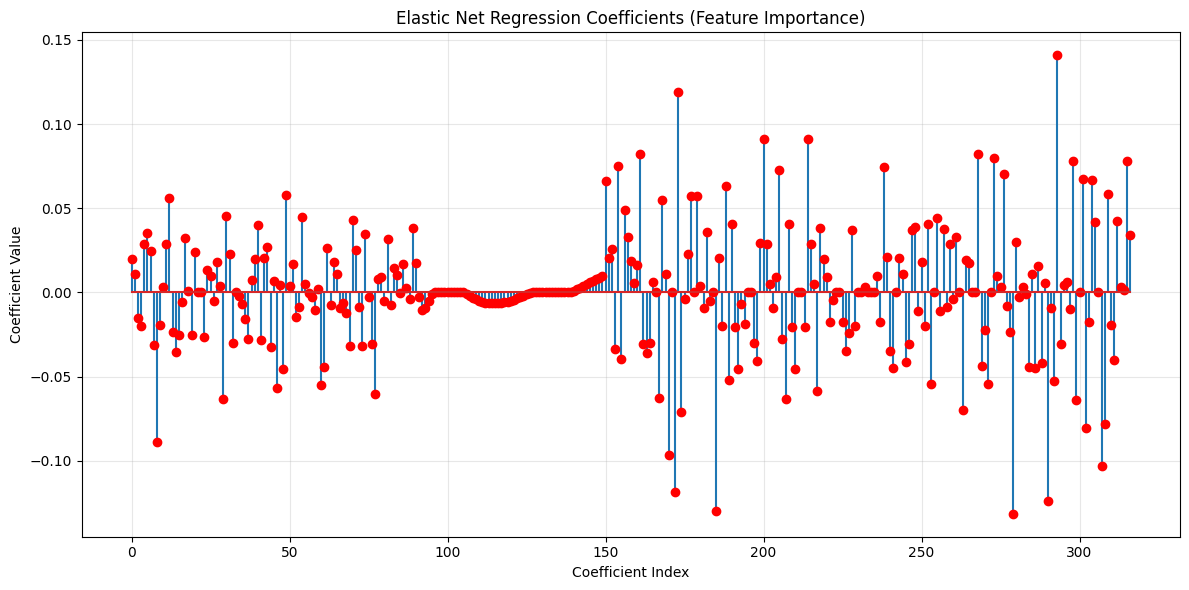

In [26]:
# Plot the coefficients
plt.figure(figsize=(12, 6))
plt.stem(range(len(coef)), coef, markerfmt='ro')
# plt.xticks(range(len(coef)), new_feature_list, rotation=90)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('Elastic Net Regression Coefficients (Feature Importance)')
plt.tight_layout()
plt.grid(True, alpha=0.3)

In [27]:
non_zero_coeff = []
non_zero_features = []
for index, value in enumerate(coef):
    if value == 0:
        continue
    non_zero_coeff.append(value)
    non_zero_features.append(new_feature_list[index])

In [28]:
### Feature importance 

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': non_zero_features,
    'Importance': non_zero_coeff
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

In [29]:
feature_importances

,Feature,Importance
233,Industry_subgroup_Metals & Mining,-0.131488
155,domicile_country_China,-0.129798
244,Industry_subgroup_Software,-0.124085
144,seniorioty_adj_Secured,-0.118686
259,event_type_subcategory_sum_Missing Coupon paym...,-0.103339
...,...,...
135,currency_INR,0.082272
180,exchange_country_South Korea,0.091341
168,domicile_country_South Korea,0.091341
145,seniorioty_adj_Senior Secured,0.119072


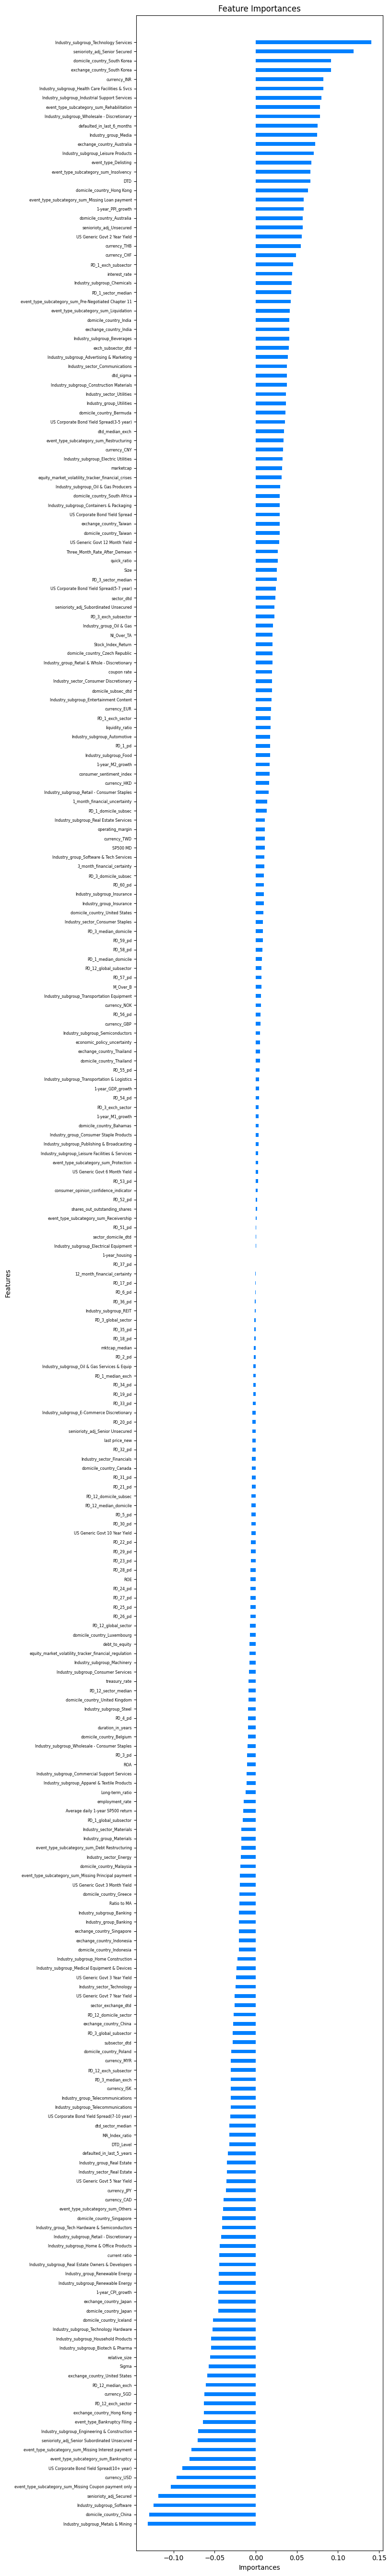

In [30]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color=(0, 0.5, 1), height=0.4)  # Adjust the height for spacing
# Increase figure height to accommodate the spacing
plt.gcf().set_size_inches(10, max(2, len(feature_importances) * 0.2))

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Importances')  # Label for the x-axis
plt.title('Feature Importances')  # Title of the plot
plt.margins(y=0.01) # Include margins adjustment to remove extra whitespace
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')
plt.savefig(os.path.join(OUTPUT_PATH,'feature_importance.png'))

plt.show()

5-fold CV

In [31]:
features = pd.concat([train_features, test_features], axis=0, ignore_index=True)
features

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,7.500,-117.46020,-0.000189,125.407139,177.213028,134.012054,198.8153,191.364395,223.346344,0.1983,...,True,False,False,False,False,False,False,False,False,False
1,6.000,166.38276,0.000768,-4.603446,101.613617,77.032829,123.3998,105.932022,139.111115,0.0355,...,False,False,False,False,False,False,False,False,False,False
2,11.000,119.85752,0.000678,-11.950380,104.545959,77.416649,129.4317,111.818001,139.717407,0.0101,...,False,False,False,False,False,False,False,False,False,False
3,9.125,653.51208,0.001638,-2.494861,90.736633,64.654129,95.3731,92.141212,121.666237,0.0152,...,False,False,False,False,False,False,False,False,False,False
4,9.250,231.89472,0.000664,4.823413,98.533821,68.759308,93.4174,107.424469,139.741165,1.2865,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,3.250,147.33344,0.000556,3.538252,128.976395,95.360374,138.8445,138.946106,172.733887,0.0000,...,False,False,False,False,False,False,False,False,False,False
1721,10.000,175.31656,0.000554,-4.067337,121.170998,92.879501,123.2500,131.104904,162.916901,0.7516,...,False,True,False,False,False,False,False,False,False,False
1722,7.450,315.81748,0.000747,8.604100,126.786606,89.018188,114.9728,131.522430,171.701096,0.0864,...,False,False,False,False,False,False,False,False,False,False
1723,0.500,31.75120,-0.000157,-4.373852,126.595230,105.460007,121.6212,147.382416,163.772141,4.8375,...,False,False,False,False,False,False,False,False,False,False


In [32]:
labels = pd.concat([train_labels, test_labels], axis=0, ignore_index=True)
labels

,rr1_30
0,0.082481
1,0.378845
2,0.836149
3,0.987208
4,1.021458
...,...
1720,0.471411
1721,0.823750
1722,0.241612
1723,0.762054


In [33]:
pipeline = Pipeline([
        ('scaler', scaler),
        ('lasso', ElasticNet(
            max_iter=10000,
            tol=1e-4,
            random_state=42,
            **best_params
        ))
    ])
# pipeline.fit(train_features, train_labels)

In [34]:
train_preds, oof_preds, feat_importances, train_metrics, val_metrics = run_kfold_eval(features, labels.to_numpy(), n_folds=5, model=pipeline, model_params=None, output_path=OUTPUT_PATH, name="xgboost")

  0%|          | 0/5 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.347e-01, tolerance: 1.527e-02
  model = cd_fast.enet_coordinate_descent(
 20%|██        | 1/5 [03:43<14:54, 223.58s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.483e-01, tolerance: 1.532e-02
  model = cd_fast.enet_coordinate_descent(
 40%|████      | 2/5 [07:05<10:32, 210.96s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linea

In [35]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in train_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Training average mean absolute error: {mae/i}")
print(f"Training average mean absolute percentage error: {mape/i}")
print(f"Training average root mean squared error: {rmse/i}")
print(f"Training average R2: {rsqr/i}")

Training average mean absolute error: 0.32505436434046364
Training average mean absolute percentage error: 3589.558672462916
Training average root mean squared error: 0.24150364209542827
Training average R2: 0.46960936436514267


In [36]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in val_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Test average mean absolute error: {mae/i}")
print(f"Test average mean absolute percentage error: {mape/i}")
print(f"Test average root mean squared error: {rmse/i}")
print(f"Test average R2: {rsqr/i}")

Test average mean absolute error: 0.3300776645541541
Test average mean absolute percentage error: 3672.7760772757583
Test average root mean squared error: 0.28877510993350325
Test average R2: 0.23716522701709372
